## Load package and seth path

In [2]:
%matplotlib inline

import os,sys
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio
#!pip install geopy
#!pip install boltons
from pathlib import Path
from geofeather.pygeos import to_geofeather, from_geofeather
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rasterio.plot import show
from IPython.display import display #when printing geodataframes, put it in columns -> use display(df)
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, LinearLocator, MaxNLocator)
import pygeos
from pgpkg import Geopackage
import matplotlib.pyplot as plt
import copy

sys.path.append("C:\Projects\Coastal_Infrastructure\scripts")
import fetch
import cisi
import extract
import cisi_exposure
plt.rcParams['figure.figsize'] = [20, 20]

from osgeo import gdal
gdal.SetConfigOption("OSM_CONFIG_FILE", os.path.join("..","osmconf.ini"))



### Set pathways

In [3]:
base_path = os.path.abspath('C:/Users/snn490/surfdrive/Outputs/Exposure/health_polygons') #this path contains all data that's needed as input and will contain directories to export outputs

# Set path to inputdata
osm_data_path = os.path.abspath(os.path.join('C:/Users/snn490/surfdrive/Datasets/OpenStreetMap')) #path to map with infra-gpkg's 

# path to save outputs - automatically made, not necessary to change output pathways
output_infra_path = os.path.abspath(os.path.join(base_path, 'extract')) #save interim calculations

# path to our python scripts
sys.path.append(os.path.join('..','scripts'))

#Create folders for outputs (GPKGs and pngs)
Path(output_infra_path).mkdir(parents=True, exist_ok=True)

## Extract health data

In [34]:
areas = ["Zuid-Holland"]
for area in areas:
    data = '{}.osm.pbf'.format(area) #make directory to data
    df_point = extract.social_infrastructure_point(os.path.join(osm_data_path, data))
    df_polygon = extract.social_infrastructure_polygon(os.path.join(osm_data_path, data))

query is finished, lets start the loop


100%|█████████████████████████████████████████████████████████████████████| 2112895/2112895 [01:40<00:00, 20931.87it/s]


query is finished, lets start the loop


100%|████████████████████████████████████████████████████████████████████████████████| 116/116 [00:48<00:00,  2.39it/s]


query is finished, lets start the loop


100%|█████████████████████████████████████████████████████████████████████| 1773220/1773220 [02:33<00:00, 11568.17it/s]


In [47]:
#print("Extraction of requested infrastructure is complete for group '{}' in area '{}'. This data will now be exported as geofeather...".format(group, area))
to_geofeather(df_polygon, os.path.join(output_infra_path, '{}_{}.feather'.format(area, 'df_polygon')), crs="EPSG:4326") #save as geofeather
#Export fetched exposure data as geopackage
temp_df = cisi_exposure.transform_to_gpd(df_polygon)
temp_df.to_file(os.path.join(output_infra_path, '{}_{}.gpkg'.format(area,'df_polygon')), layer=' ', driver="GPKG")
#with Geopackage(os.path.join(fetched_infra_path, '{}_{}.gpkg'.format(area,group)), 'w') as out:
#    out.add_layer(fetched_data_dict[group], name=' ', crs='EPSG:4326')


## calculate average area per infrastructure type

In [4]:
def compare_point_to_polygon(df_point, df_polygon):
    """
    Function that removes points with overlapping polygons if asset type is similar    
    Arguments:
        *df_point* : a geopandas GeoDataFrame with specified unique healthcare point data.
        *df_polygon* : a geopandas GeoDataFrame with specified unique healthcare polygons.       
    Returns:
        *GeoDataFrame* : a geopandas GeoDataFrame with unique healthcare assets (point data)
    """   

    #check for each polygon which points are overlaying with it 
    df_polygon['geometry'] = pygeos.buffer(df_polygon.geometry,0) #avoid intersection
    spat_tree = pygeos.STRtree(df_polygon.geometry) # https://pygeos.readthedocs.io/en/latest/strtree.html
    for point_row in df_point.itertuples():
        df_polygon_overlap = (df_polygon.loc[spat_tree.query(point_row.geometry,predicate='intersects').tolist()]).sort_index(ascending=True) #get point that overlaps with polygon
        if not df_polygon_overlap.empty:
            #if point_row.asset in df_polygon_overlap['asset'].tolist(): #check if infrastructure type is the same
            df_point = df_point.drop(point_row.Index)
    
    return df_point.reset_index(drop=True)

In [10]:
#import data
area = 'Zuid-Holland'
df_point = from_geofeather(os.path.join(output_infra_path, '{}_{}.feather'.format(area,'health_point'))) #open as geofeather 
df_polygon = from_geofeather(os.path.join(output_infra_path, '{}_{}.feather'.format(area,'health_polygon'))) #open as geofeather 

#remove duplicates
df_point_filtered = compare_point_to_polygon(df_point, df_polygon) #remove duplicates from point data

#area calculations for polygons
df_polygon.insert(1, "area_degrees", "") #add assettype as column after first column for length calculations
if not df_polygon.empty:
    df_polygon["area_degrees"] = pygeos.area(df_polygon.geometry) #calculate area in degrees per object and put in dataframe
area_per_type = df_polygon.groupby(['asset'])['area_degrees'].mean() #get mean area per infrastructure type

#assign mean area to infrastructure type point data
df_point_filtered.insert(1, "area_degrees", "")#create area deree column df point_filtered data
poly_types = area_per_type.index.tolist() #all polygon infra types to list
point_types = df_point_filtered.asset.unique().tolist() #all point infra types to list

for infra_type in poly_types:
    if infra_type in point_types:
        df_point_filtered.loc[df_point_filtered['asset'] == infra_type, 'area_degrees'] = area_per_type.loc[infra_type]
        
#assign area to infrastructure types that are absent in polygon dataset
missing_infra_types_lst = list(set(point_types) - set(poly_types)) #get infra types that are in point_types but not poly_types
mean_value = area_per_type.drop(['hospital', 'clinic']).mean() #get mean area of health facilities neglecting area of hospitals

for infra_type in missing_infra_types_lst:
    df_point_filtered.loc[df_point_filtered['asset'] == infra_type, 'area_degrees'] = mean_value
    
#create polygon out of point data (see https://stackoverflow.com/questions/57507739/python-how-to-create-square-buffers-around-points-with-a-distance-in-meters)
df_point_filtered = df_point_filtered.rename(columns={'geometry' : 'geometry_point'})
df_point_filtered.insert(1, "geometry", "") #add geometry column to store polygon geometries
df_point_filtered['radius_degrees'] = (df_point_filtered['area_degrees']**(1/2))/2

for row in df_point_filtered.itertuples():
    df_point_filtered['geometry'].loc[row.Index] = pygeos.buffer(row.geometry_point, row.radius_degrees, cap_style='square')
    
#combine health point and polygon df's
df_point_filtered = df_point_filtered.drop(columns=['geometry_point', 'radius_degrees','area_degrees'])
df_polygon = df_polygon.drop(columns=['area_degrees'])
df_health = df_polygon.append(df_point_filtered).reset_index(drop=True)

#print("Extraction of requested infrastructure is complete for group '{}' in area '{}'. This data will now be exported as geofeather...".format(group, area))
to_geofeather(df_health, os.path.join(base_path, '{}_{}.feather'.format(area, 'health')), crs="EPSG:4326") #save as geofeather
#Export fetched exposure data as geopackage
temp_df = cisi_exposure.transform_to_gpd(df_health)
temp_df.to_file(os.path.join(base_path, '{}_{}.gpkg'.format(area,'health')), layer=' ', driver="GPKG")
#with Geopackage(os.path.join(fetched_infra_path, '{}_{}.gpkg'.format(area,group)), 'w') as out:
#    out.add_layer(fetched_data_dict[group], name=' ', crs='EPSG:4326')


In [11]:
def extended_health_data(area,fetched_infra_path,base_path):
    """function to extent health infrastrastructure data for an area, by transforming point data into polygon data and append it to polygon dataset. 

    Args:
        *area* (str): area to be analyzed
        *fetched_infra_path* (str): directory to output location of the extracted infrastructure data 
        *base_path* (str): directory to base folder
    """
    
    #import data
    df_point = from_geofeather(os.path.join(fetched_infra_path, '{}_{}.feather'.format(area,'health_point'))) #open as geofeather 
    df_polygon = from_geofeather(os.path.join(fetched_infra_path, '{}_{}.feather'.format(area,'health_polygon'))) #open as geofeather 

    #remove duplicates
    df_point_filtered = compare_point_to_polygon(df_point, df_polygon) #remove duplicates from point data

    #area calculations for polygons
    df_polygon.insert(1, "area_degrees", "") #add assettype as column after first column for length calculations
    if not df_polygon.empty:
        df_polygon["area_degrees"] = pygeos.area(df_polygon.geometry) #calculate area in degrees per object and put in dataframe
    area_per_type = df_polygon.groupby(['asset'])['area_degrees'].mean() #get mean area per infrastructure type

    #assign mean area to infrastructure type point data
    df_point_filtered.insert(1, "area_degrees", "")#create area deree column df point_filtered data
    poly_types = area_per_type.index.tolist() #all polygon infra types to list
    point_types = df_point_filtered.asset.unique().tolist() #all point infra types to list

    for infra_type in poly_types:
        if infra_type in point_types:
            df_point_filtered.loc[df_point_filtered['asset'] == infra_type, 'area_degrees'] = area_per_type.loc[infra_type]

    #assign area to infrastructure types that are absent in polygon dataset
    missing_infra_types_lst = list(set(point_types) - set(poly_types)) #get infra types that are in point_types but not poly_types
    mean_value = area_per_type.drop(['hospital', 'clinic']).mean() #get mean area of health facilities neglecting area of hospitals

    for infra_type in missing_infra_types_lst:
        df_point_filtered.loc[df_point_filtered['asset'] == infra_type, 'area_degrees'] = mean_value

    #create polygon out of point data (see https://stackoverflow.com/questions/57507739/python-how-to-create-square-buffers-around-points-with-a-distance-in-meters)
    df_point_filtered = df_point_filtered.rename(columns={'geometry' : 'geometry_point'})
    df_point_filtered.insert(1, "geometry", "") #add geometry column to store polygon geometries
    df_point_filtered['radius_degrees'] = (df_point_filtered['area_degrees']**(1/2))/2

    for row in df_point_filtered.itertuples():
        df_point_filtered['geometry'].loc[row.Index] = pygeos.buffer(row.geometry_point, row.radius_degrees, cap_style='square')

    #combine health point and polygon df's
    df_point_filtered = df_point_filtered.drop(columns=['geometry_point', 'radius_degrees','area_degrees'])
    df_polygon = df_polygon.drop(columns=['area_degrees'])
    df_health = df_polygon.append(df_point_filtered).reset_index(drop=True)

    #print("Extraction of requested infrastructure is complete for group '{}' in area '{}'. This data will now be exported as geofeather...".format(group, area))
    to_geofeather(df_health, os.path.join(base_path, '{}_{}.feather'.format(area, 'health')), crs="EPSG:4326") #save as geofeather
    #Export fetched exposure data as geopackage
    temp_df = cisi_exposure.transform_to_gpd(df_health)
    temp_df.to_file(os.path.join(base_path, '{}_{}.gpkg'.format(area,'health')), layer=' ', driver="GPKG")
    #with Geopackage(os.path.join(fetched_infra_path, '{}_{}.gpkg'.format(area,group)), 'w') as out:
    #    out.add_layer(fetched_data_dict[group], name=' ', crs='EPSG:4326')


In [120]:
df_point_filtered

,osm_id,geometry,area_degrees,asset,geometry_point,radius_degrees
0,95702648,"POLYGON ((4.78 51.9, 4.78 51.9, 4.78 51.9, 4.7...",6.60982e-08,pharmacy,POINT (4.78 51.9),0.000128548
1,206392665,"POLYGON ((4.38 51.9, 4.38 51.9, 4.38 51.9, 4.3...",6.66196e-06,hospital,POINT (4.38 51.9),0.00129054
2,278013448,"POLYGON ((4.3 52, 4.3 52, 4.3 52, 4.3 52, 4.3 ...",6.60982e-08,pharmacy,POINT (4.3 52),0.000128548
3,298488442,"POLYGON ((4.61 51.9, 4.61 51.9, 4.61 51.9, 4.6...",6.60982e-08,pharmacy,POINT (4.61 51.9),0.000128548
4,321558290,"POLYGON ((4.5 52.2, 4.5 52.2, 4.5 52.2, 4.5 52...",6.60982e-08,pharmacy,POINT (4.5 52.2),0.000128548
...,...,...,...,...,...,...
979,7274106713,"POLYGON ((4.25 52, 4.25 52, 4.25 52, 4.25 52, ...",7.92404e-08,doctors,POINT (4.25 52),0.000140748
980,7308912055,"POLYGON ((4.54 52.2, 4.54 52.2, 4.54 52.2, 4.5...",7.92404e-08,doctors,POINT (4.54 52.2),0.000140748
981,7398324056,"POLYGON ((4.35 52, 4.35 52, 4.35 52, 4.35 52, ...",3.10408e-08,physiotherapist,POINT (4.35 52),8.80921e-05
982,7495438552,"POLYGON ((4.49 52.2, 4.49 52.2, 4.49 52.2, 4.4...",3.10408e-08,physiotherapist,POINT (4.49 52.2),8.80921e-05


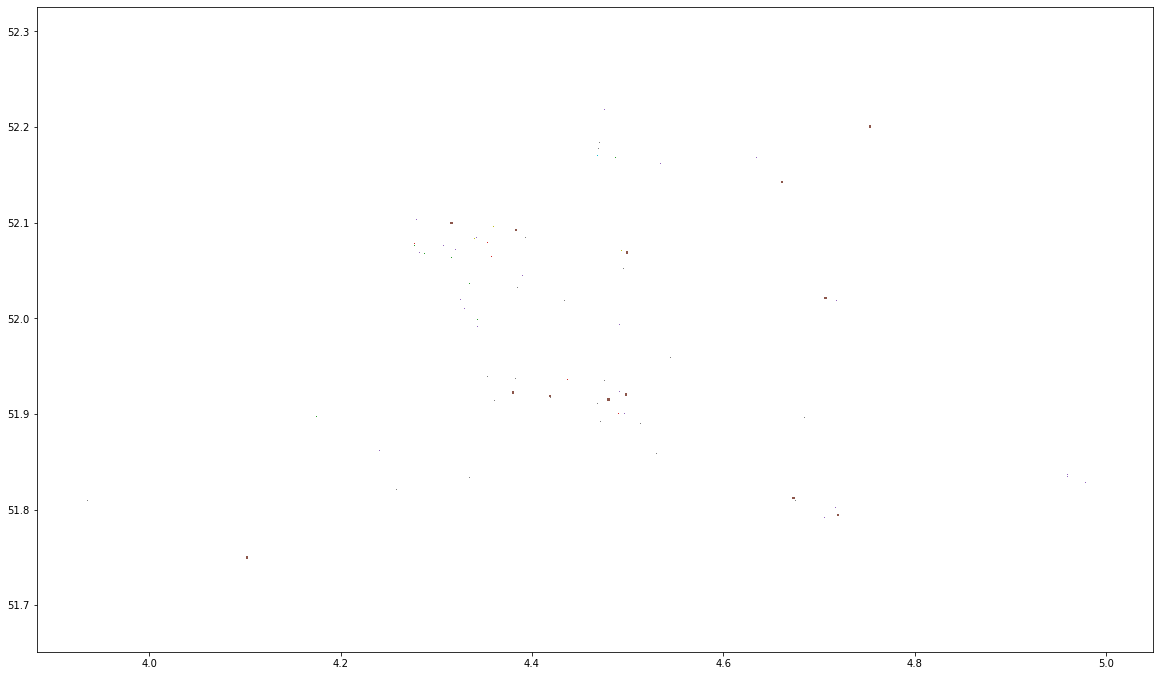

In [121]:
temp_df = cisi_exposure.transform_to_gpd(df_point_filtered)
temp_df.plot(column='asset')

In [14]:
check = from_geofeather(os.path.join(r'\\labsdfs.labs.vu.nl\labsdfs\BETA-IVM-BAZIS\snn490\Outputs\Exposure\CISI_reclass_roads\Fetched_infrastructure', 'ITA_roads.feather'))

In [ ]:
check